# Remove Abnormal Data from Training Set

Load DataFrame from `0_min/train.pkl`

Define multile functions that take a dataframe and return a boolean mask for entries to keep.

Combine masks in the end into a final mask, then it can be applied to `0_full` version as well if that's preferred.

In [1]:
import pandas as pd
import numpy as np
import os

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor

In [2]:
if ('my_home_path' not in os.environ) and ('MY_HOME_PATH' in os.environ):
    os.environ['my_home_path'] = os.environ['MY_HOME_PATH'] # because stupid :(

In [29]:
train_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../0_min/train.pkl")

# total unique NORAD_IDs
# len(train_df.NORAD_CAT_ID.unique())

In [40]:
# np.random.choice(train_df.NORAD_CAT_ID.unique(),10)

In [105]:
# just using a small subset for testing
# sample_ids = [12223, 26285, 10760, 14345, 34588, 330, 20970]
sample_ids = [12223, 26285, 10760, 14345, 34588, 330, 20970, 35253, 38899, 36390, 27507, 31539,  8386,  6299, 18428, 17228, 42126]
sample_ids += list(np.random.choice(train_df.NORAD_CAT_ID.unique(),20))
sample_df = train_df[train_df.NORAD_CAT_ID.isin(sample_ids)]

## Remove Erroneous Data
First we start by removing data which we don't want to include in our model.  This includes values which are outside of acceptable ranges or are physically impossible.

In [5]:
# Early TLEs are more prone to errors, cut off should be somewhere in the 80s
# TODO: putting in 1990 for now to be on the safe side

def more_recent_only(df):
    mask = df.EPOCH > "1990"
    return mask

In [6]:
# Space track LEO definition: Mean Motion > 11.25 and Eccentricity < 0.25
# This means that satellite that decay into LEO will not have non-LEO-like entries removed

def leo_check(df):
    mask = (df['MEAN_MOTION'] > 11.25) & (df['ECCENTRICITY'] < 0.25)
    return mask

In [7]:
# valid range for 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY' is 0..360

def degrees_range_check(df):
    degree_columns = ['RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY']
    mask = df[degree_columns].apply(lambda x:x.between(0,360), axis=0).all(axis=1)
    return mask

In [8]:
# valid INCLINATION range is 0..180

def inclination_range_check(df):
    mask = df['INCLINATION'].between(0,180)
    return mask

In [9]:
# TODO: Anything beyond 20 should be outliers... I think...
# > 16.5 you do get multiple entries from the same satellite, so those shouldn't be outliers
# train_df[train_df['MEAN_MOTION'] > 16.5].NORAD_CAT_ID.value_counts()    

def mean_motion_range_check(df):
    mask = df['MEAN_MOTION'].between(11.25,20)
    return mask

In [10]:
# Skipping first few entries may be a good idea due to initial readings being less accurate (?)
# TODO: using N=5 for now
# this one takes longer because of the grouping

def skip_first_n(df, n=5):
    mask = df.groupby(by="NORAD_CAT_ID", as_index=False).apply(lambda x:x.EPOCH.rank() > n).reset_index(level=0, drop=True).sort_index()
    return mask

In [11]:
anomaly_functions = [
    more_recent_only,
    leo_check,
    degrees_range_check,
    inclination_range_check,
    mean_motion_range_check,
    skip_first_n,
]

anomaly_results = []
for fn in tqdm(anomaly_functions):
    print(f"Processing function: \"{fn.__name__}\"")
    %time res = fn(train_df)
    print("==========================================================")
    res.name = fn.__name__
    anomaly_results.append(res)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing function: "more_recent_only"
CPU times: user 170 ms, sys: 47.5 ms, total: 218 ms
Wall time: 215 ms
Processing function: "leo_check"
CPU times: user 152 ms, sys: 108 ms, total: 260 ms
Wall time: 258 ms
Processing function: "degrees_range_check"
CPU times: user 1.01 s, sys: 836 ms, total: 1.85 s
Wall time: 1.84 s
Processing function: "inclination_range_check"
CPU times: user 143 ms, sys: 114 ms, total: 257 ms
Wall time: 255 ms
Processing function: "mean_motion_range_check"
CPU times: user 187 ms, sys: 70.6 ms, total: 258 ms
Wall time: 256 ms
Processing function: "skip_first_n"
CPU times: user 48 s, sys: 8.02 s, total: 56 s
Wall time: 56 s


In [12]:
# mask results

for s in anomaly_results:
    display(s.value_counts())
    
combined = pd.concat(anomaly_results, axis=1).all(axis=1)
combined.name = "combined_masks"
print("==========================================================\nMasks combined:")
display(combined.value_counts())

True     50453855
False     4785984
Name: more_recent_only, dtype: int64

True     54678326
False      561513
Name: leo_check, dtype: int64

True     55239837
False           2
Name: degrees_range_check, dtype: int64

True    55239839
Name: inclination_range_check, dtype: int64

True     54678335
False      561504
Name: mean_motion_range_check, dtype: int64

True     55167118
False       72721
Name: skip_first_n, dtype: int64

Masks combined:


True     49901955
False     5337884
Name: combined_masks, dtype: int64

## Generate a new DataFrame for Outliers

Masked version of DataFrame for unsupervised learning outlier detection

In [106]:
masked_df = train_df[combined]
masked_sample_df = masked_df[masked_df.NORAD_CAT_ID.isin(sample_ids)]

## Use Unsupervised Learning to Remove Outliers

We'll be using `LocalOutlierFactor`

  0%|          | 0/34 [00:00<?, ?it/s]

norad id: 124, rows:15518
column: INCLINATION, n_clusters_: 1, n_noise_: 14, noise %:0.00090%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 12, noise %:0.00077%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 124, rows:15518, combined noise count: 23, noise %:0.00148%


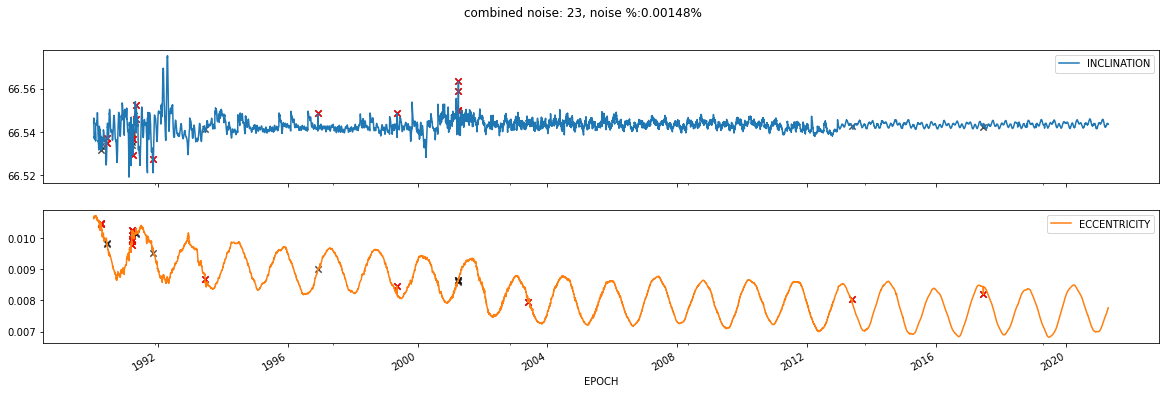

norad id: 330, rows:15137
column: INCLINATION, n_clusters_: 1, n_noise_: 30, noise %:0.00198%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 34, noise %:0.00225%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 330, rows:15137, combined noise count: 57, noise %:0.00377%


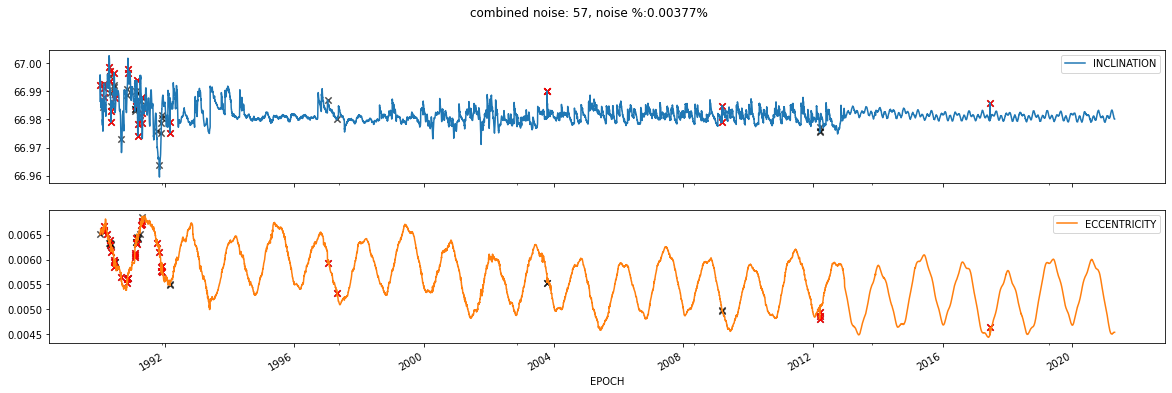

norad id: 5446, rows:10475
column: INCLINATION, n_clusters_: 1, n_noise_: 3, noise %:0.00029%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 15, noise %:0.00143%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 5446, rows:10475, combined noise count: 16, noise %:0.00153%


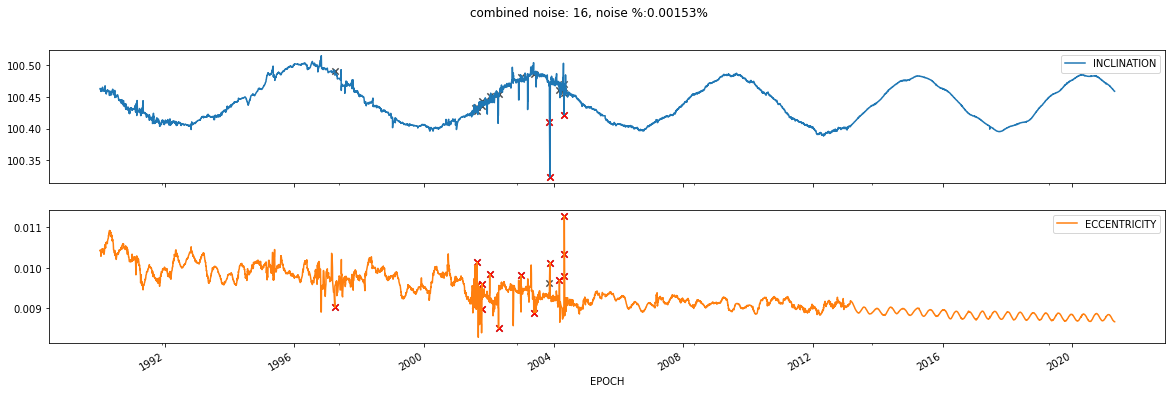

norad id: 6299, rows:359
column: INCLINATION, n_clusters_: 1, n_noise_: 3, noise %:0.00836%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 2, noise %:0.00557%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
norad id: 6299, rows:359, combined noise count: 5, noise %:0.01393%


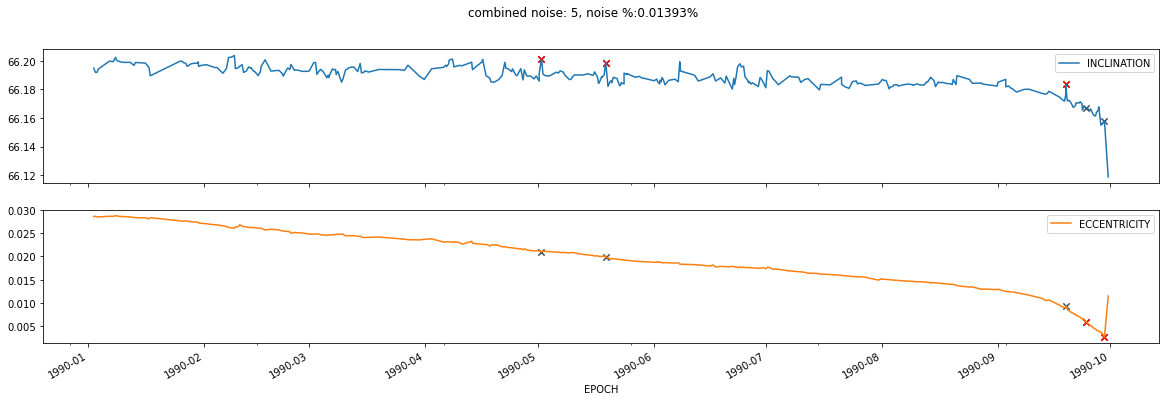

norad id: 7182, rows:13758
column: INCLINATION, n_clusters_: 1, n_noise_: 7, noise %:0.00051%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 24, noise %:0.00174%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 7182, rows:13758, combined noise count: 28, noise %:0.00204%


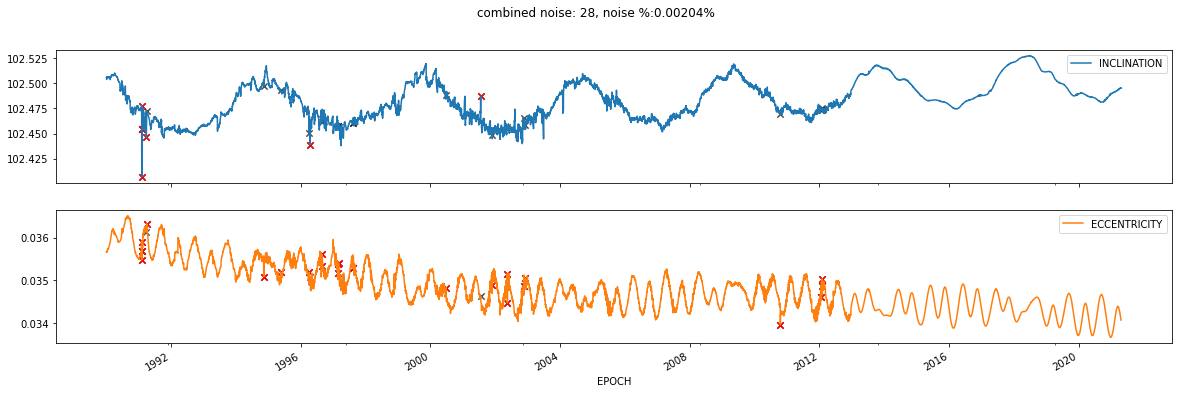

norad id: 8386, rows:1724
column: INCLINATION, n_clusters_: 1, n_noise_: 2, noise %:0.00116%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 3, noise %:0.00174%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
norad id: 8386, rows:1724, combined noise count: 5, noise %:0.00290%


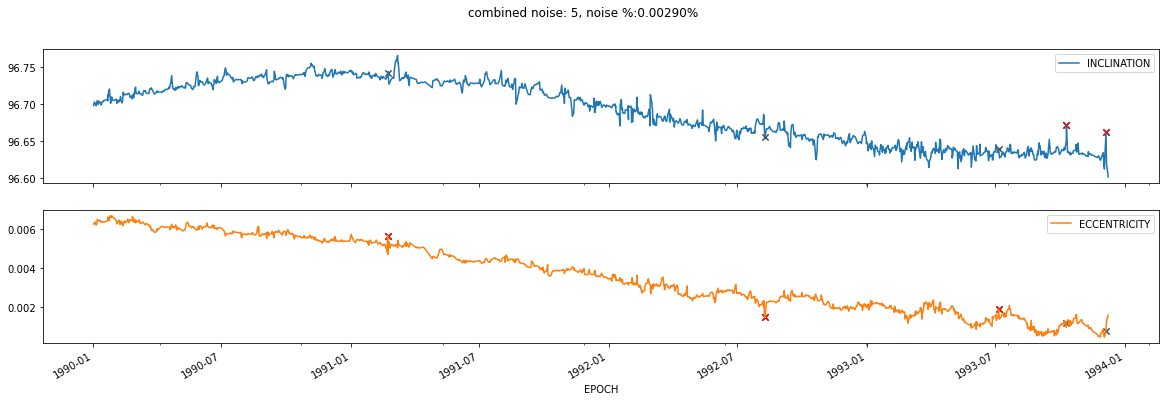

norad id: 10760, rows:14195
column: INCLINATION, n_clusters_: 1, n_noise_: 20, noise %:0.00141%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 29, noise %:0.00204%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 10760, rows:14195, combined noise count: 48, noise %:0.00338%


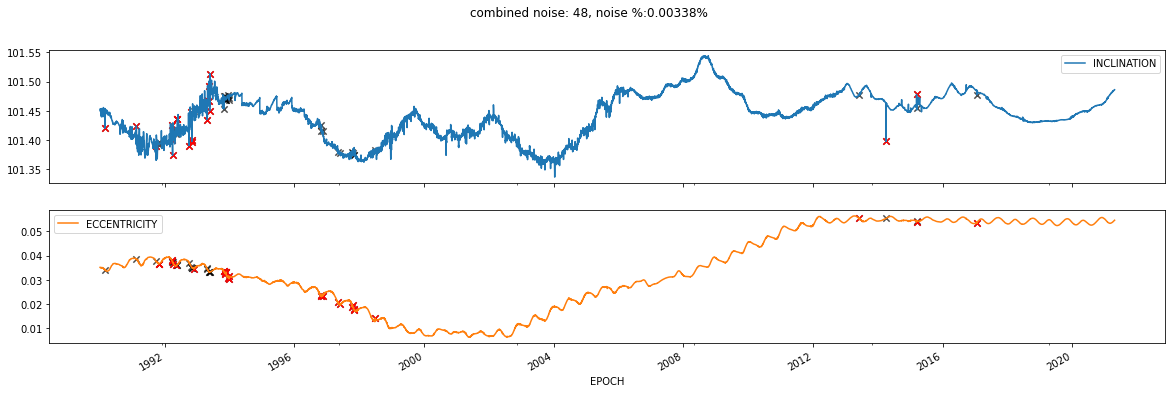

norad id: 12223, rows:14739
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.00007%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 1, noise %:0.00007%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 12223, rows:14739, combined noise count: 1, noise %:0.00007%


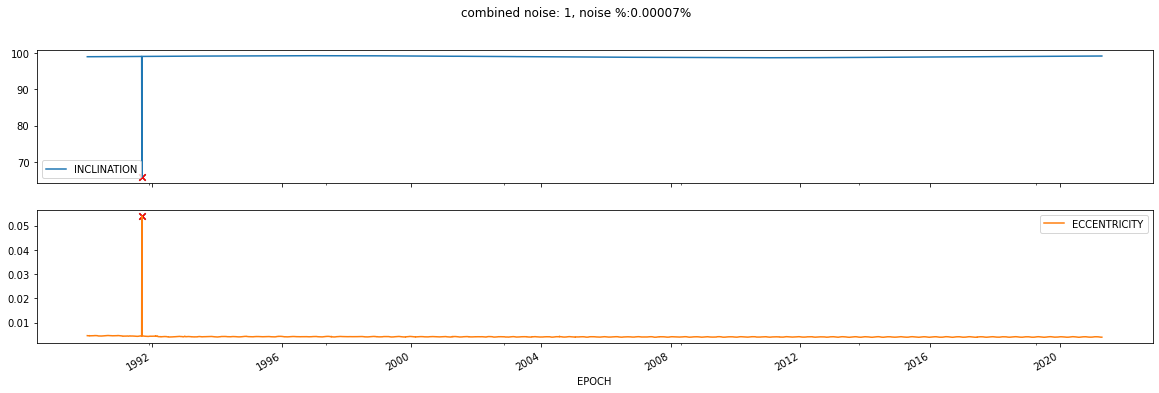

norad id: 14345, rows:12962
column: INCLINATION, n_clusters_: 1, n_noise_: 22, noise %:0.00170%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 26, noise %:0.00201%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 14345, rows:12962, combined noise count: 44, noise %:0.00339%


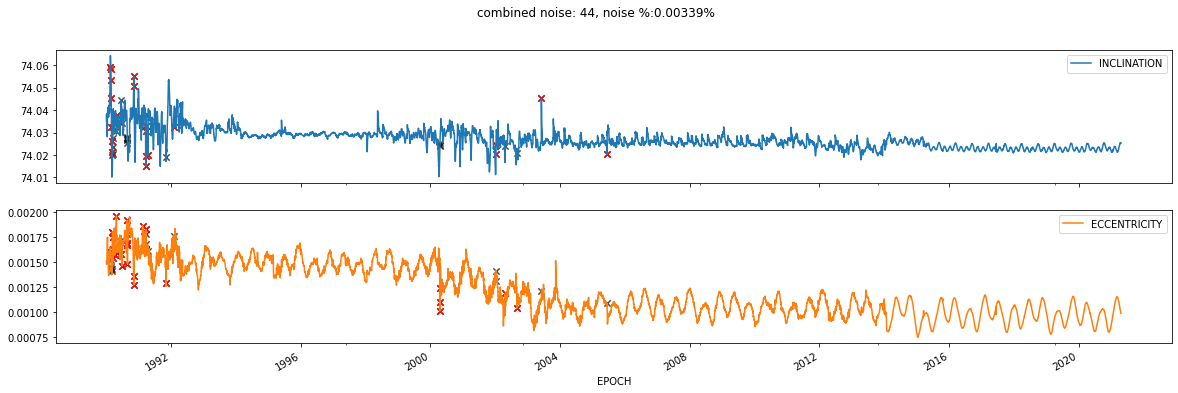

norad id: 14807, rows:14587
column: INCLINATION, n_clusters_: 1, n_noise_: 18, noise %:0.00123%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 38, noise %:0.00261%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 14807, rows:14587, combined noise count: 54, noise %:0.00370%


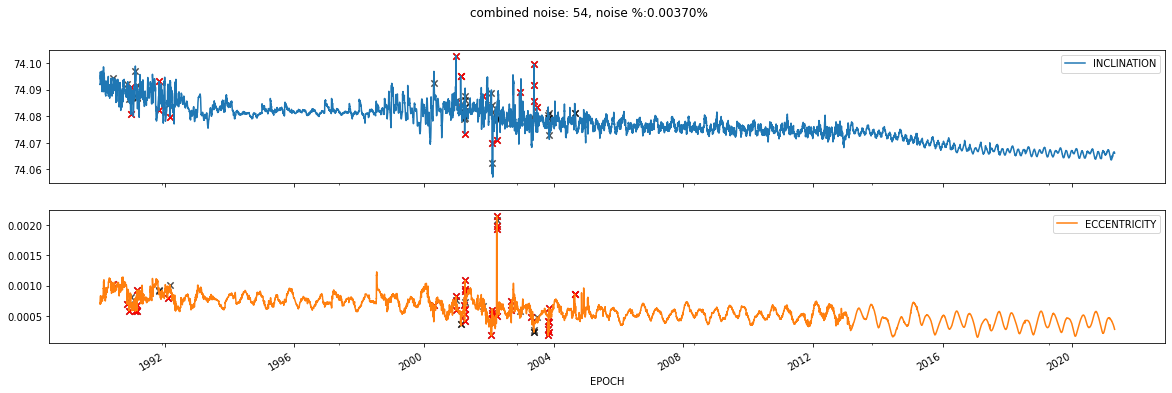

norad id: 17228, rows:755
column: INCLINATION, n_clusters_: 1, n_noise_: 3, noise %:0.00397%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 4, noise %:0.00530%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1]
norad id: 17228, rows:755, combined noise count: 7, noise %:0.00927%


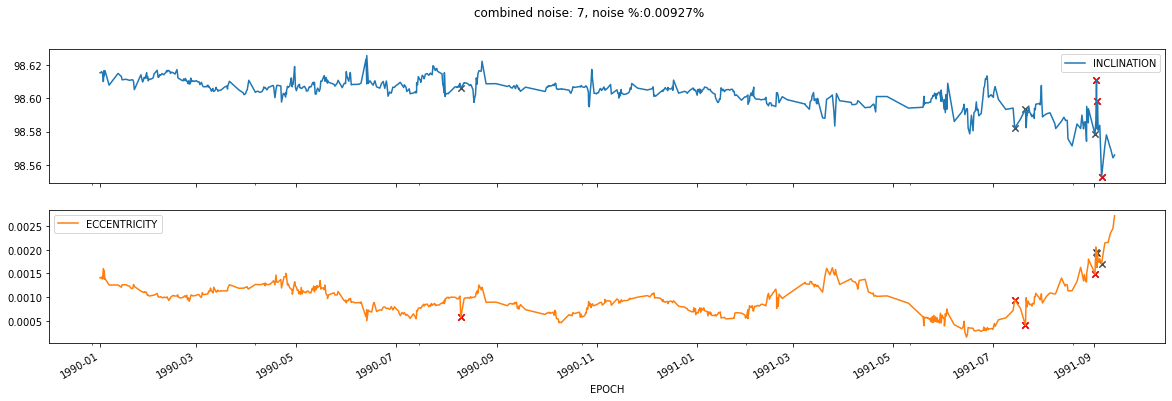

norad id: 18428, rows:7859
column: INCLINATION, n_clusters_: 1, n_noise_: 9, noise %:0.00115%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 2, noise %:0.00025%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 18428, rows:7859, combined noise count: 11, noise %:0.00140%


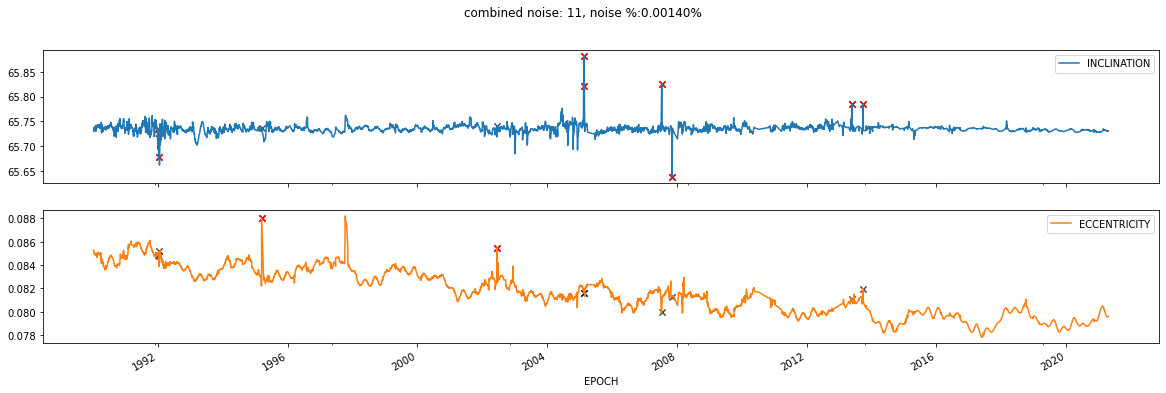

norad id: 20970, rows:6288
column: INCLINATION, n_clusters_: 1, n_noise_: 14, noise %:0.00223%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 17, noise %:0.00270%
last 30 [1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 20970, rows:6288, combined noise count: 28, noise %:0.00445%


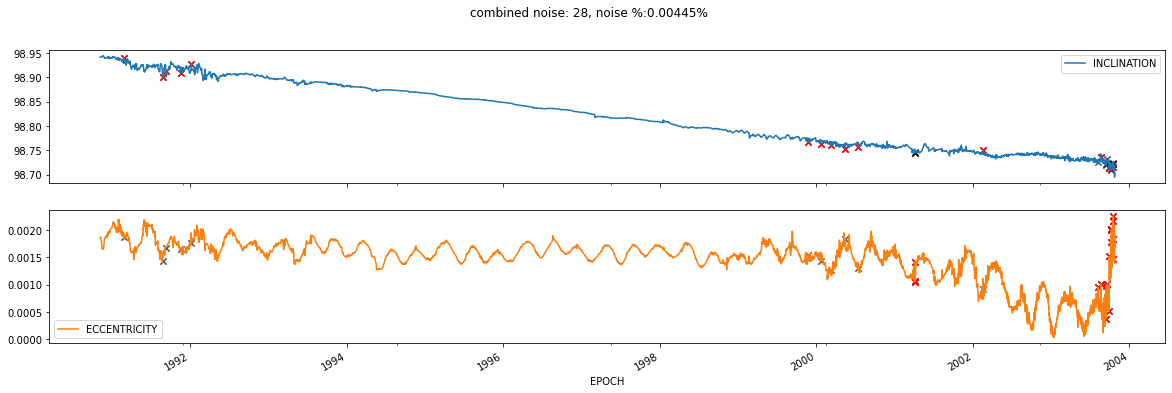

norad id: 26285, rows:6545
column: INCLINATION, n_clusters_: 1, n_noise_: 9, noise %:0.00138%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 10, noise %:0.00153%
last 30 [1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
norad id: 26285, rows:6545, combined noise count: 17, noise %:0.00260%


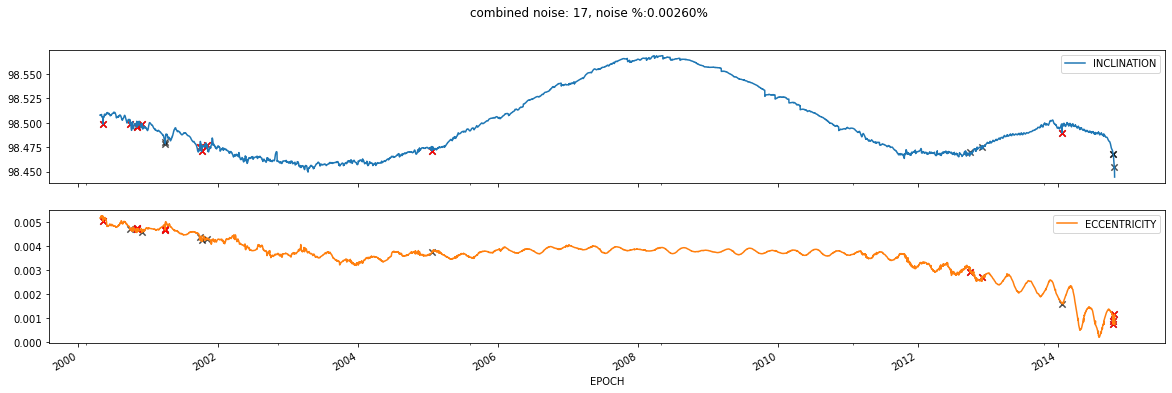

norad id: 27507, rows:7
column: INCLINATION, n_clusters_: 0, n_noise_: 7, noise %:1.00000%
column: ECCENTRICITY, n_clusters_: 0, n_noise_: 7, noise %:1.00000%
last 30 [0 0 0 0 0 0 0]
norad id: 27507, rows:7, combined noise count: 7, noise %:1.00000%


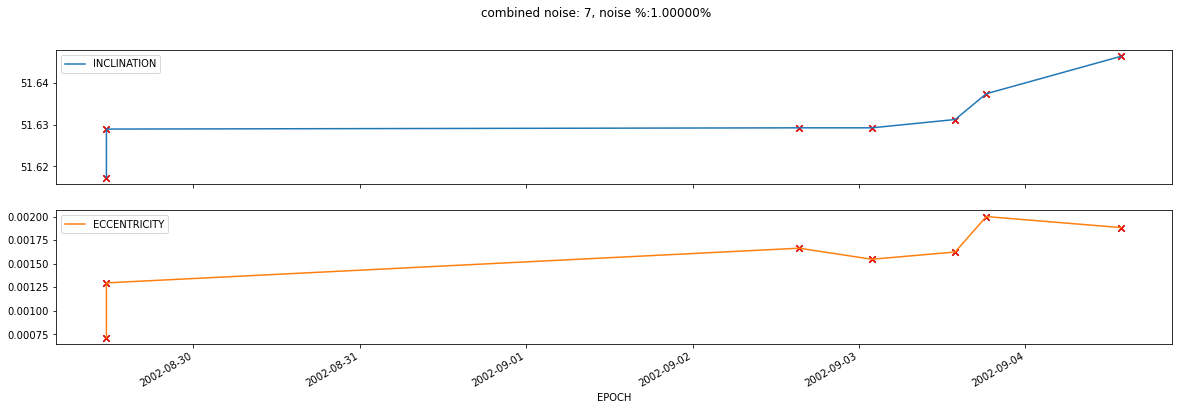

norad id: 29091, rows:55
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.01818%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 1, noise %:0.01818%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 29091, rows:55, combined noise count: 1, noise %:0.01818%


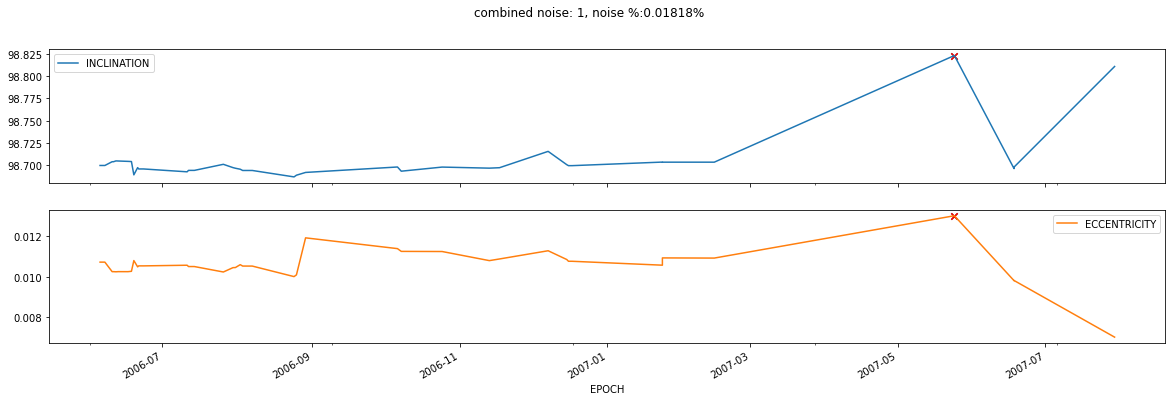

norad id: 29580, rows:2650
column: INCLINATION, n_clusters_: 1, n_noise_: 3, noise %:0.00113%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 5, noise %:0.00189%
last 30 [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
norad id: 29580, rows:2650, combined noise count: 8, noise %:0.00302%


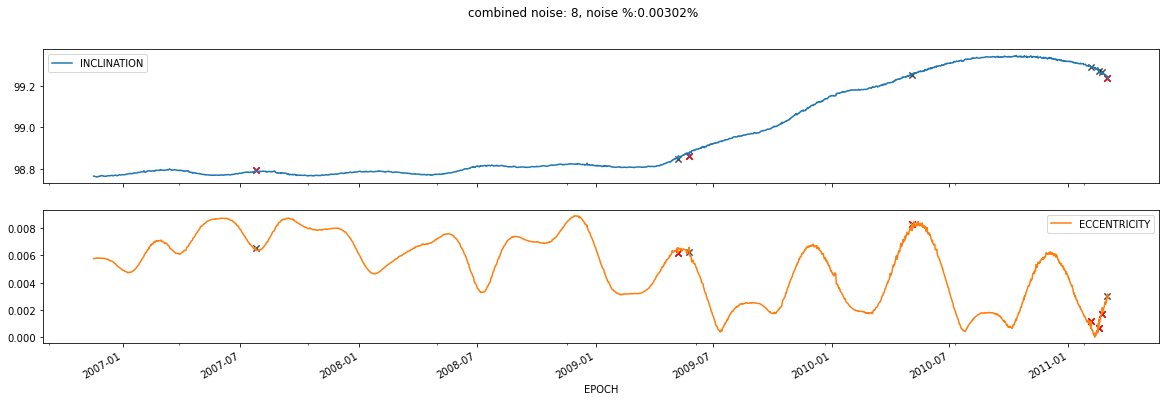

norad id: 29953, rows:7824
column: INCLINATION, n_clusters_: 1, n_noise_: 14, noise %:0.00179%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 15, noise %:0.00192%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 29953, rows:7824, combined noise count: 29, noise %:0.00371%


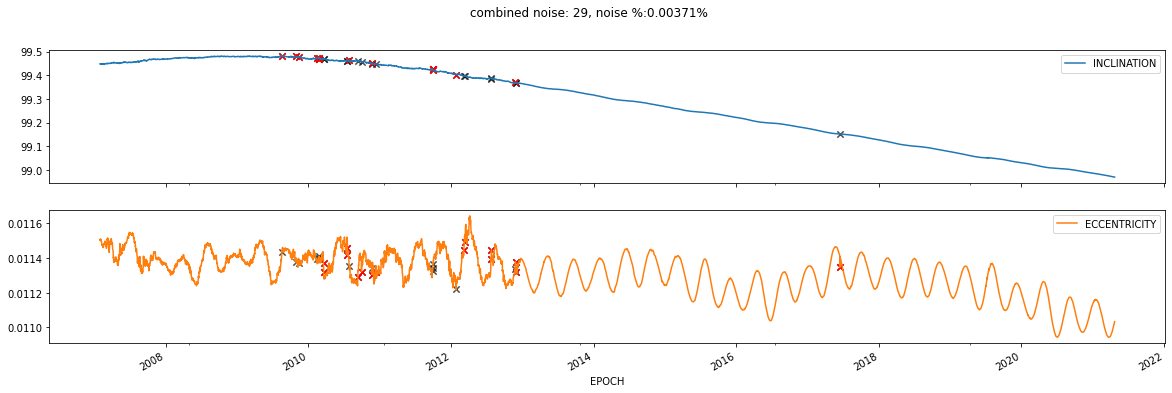

norad id: 30042, rows:3425
column: INCLINATION, n_clusters_: 1, n_noise_: 17, noise %:0.00496%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 10, noise %:0.00292%
last 30 [0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
norad id: 30042, rows:3425, combined noise count: 25, noise %:0.00730%


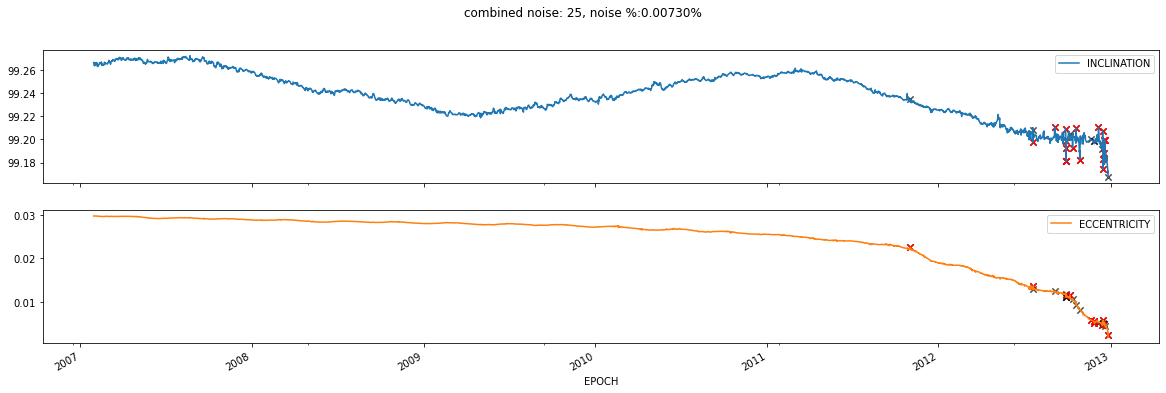

norad id: 31539, rows:3563
column: INCLINATION, n_clusters_: 1, n_noise_: 3, noise %:0.00084%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 14, noise %:0.00393%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 31539, rows:3563, combined noise count: 16, noise %:0.00449%


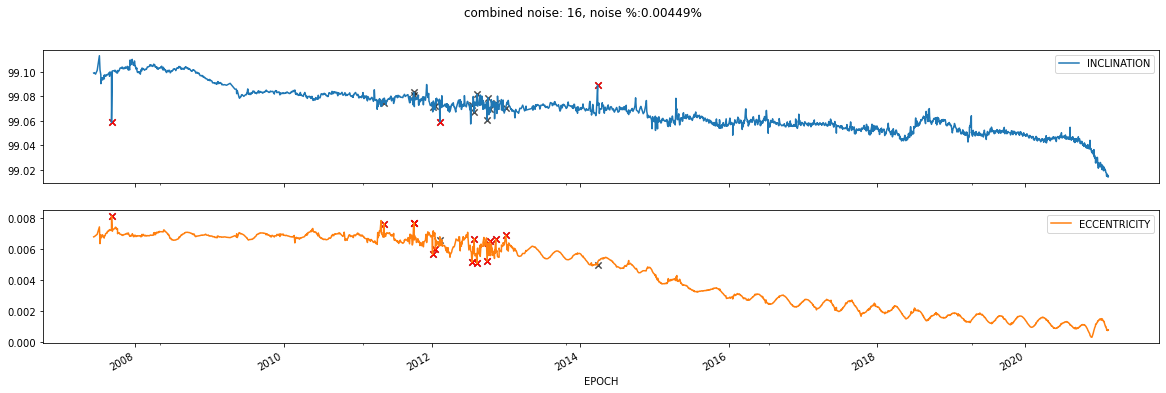

norad id: 31592, rows:1706
column: INCLINATION, n_clusters_: 1, n_noise_: 8, noise %:0.00469%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 2, noise %:0.00117%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 31592, rows:1706, combined noise count: 9, noise %:0.00528%


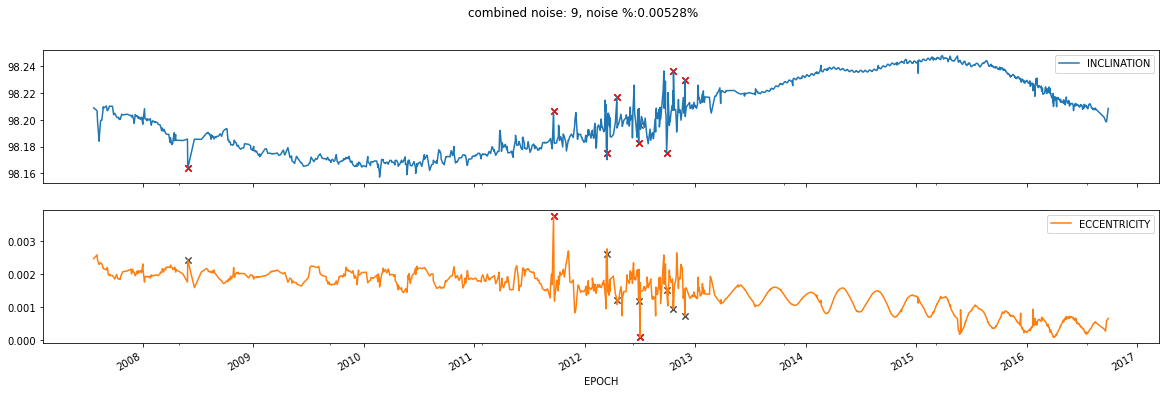

norad id: 31996, rows:1386
column: INCLINATION, n_clusters_: 1, n_noise_: 4, noise %:0.00289%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 6, noise %:0.00433%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 31996, rows:1386, combined noise count: 10, noise %:0.00722%


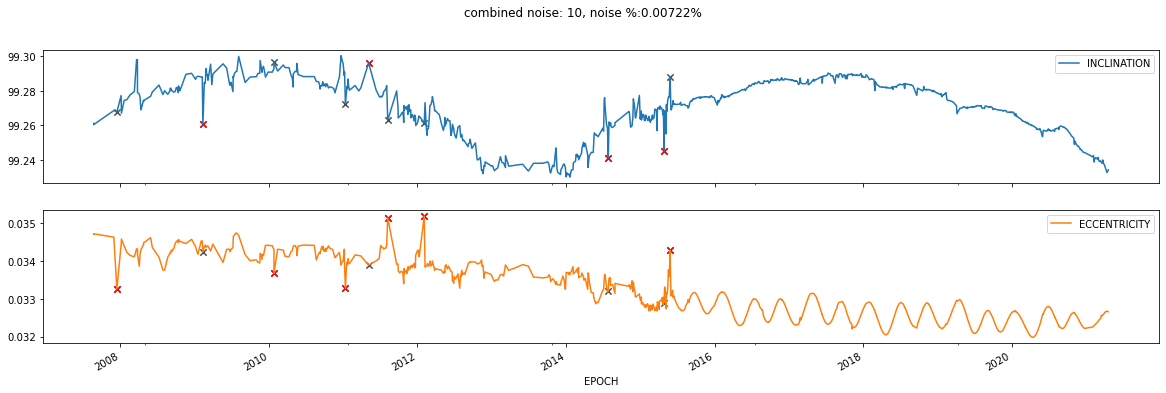

norad id: 32351, rows:2131
column: INCLINATION, n_clusters_: 1, n_noise_: 4, noise %:0.00188%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 7, noise %:0.00328%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 32351, rows:2131, combined noise count: 9, noise %:0.00422%


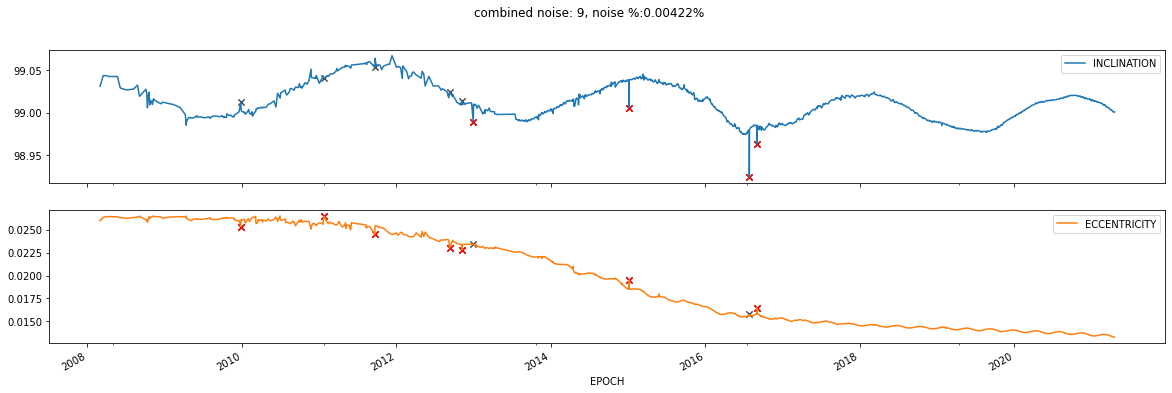

norad id: 32754, rows:27
column: INCLINATION, n_clusters_: 1, n_noise_: 0, noise %:0.00000%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 0, noise %:0.00000%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 32754, rows:27, combined noise count: 0, noise %:0.00000%


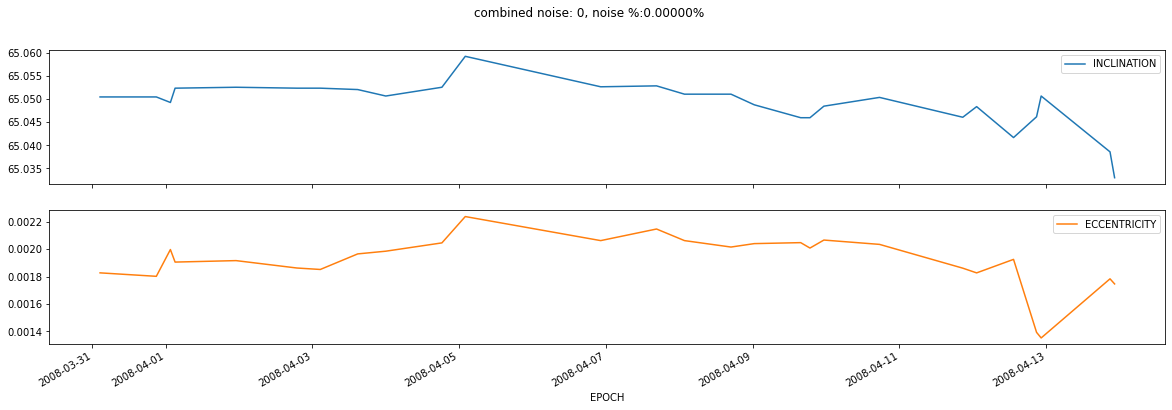

norad id: 32907, rows:32
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.03125%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 0, noise %:0.00000%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
norad id: 32907, rows:32, combined noise count: 1, noise %:0.03125%


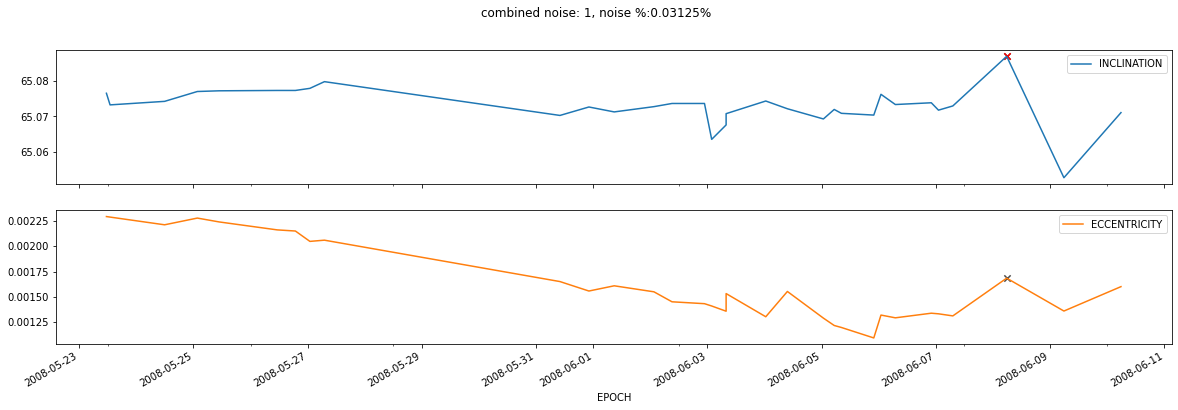

norad id: 34588, rows:6316
column: INCLINATION, n_clusters_: 1, n_noise_: 6, noise %:0.00095%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 7, noise %:0.00111%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 34588, rows:6316, combined noise count: 12, noise %:0.00190%


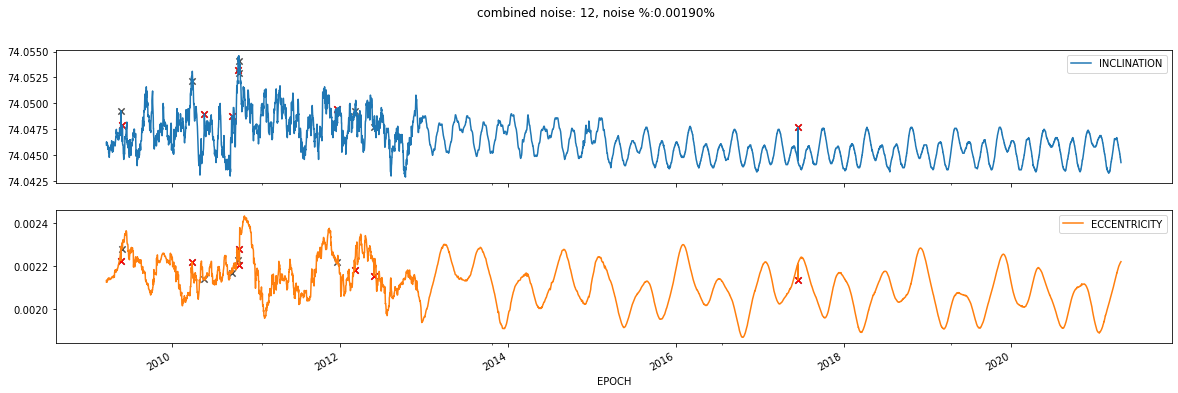

norad id: 35253, rows:2542
column: INCLINATION, n_clusters_: 1, n_noise_: 11, noise %:0.00433%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 6, noise %:0.00236%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 35253, rows:2542, combined noise count: 16, noise %:0.00629%


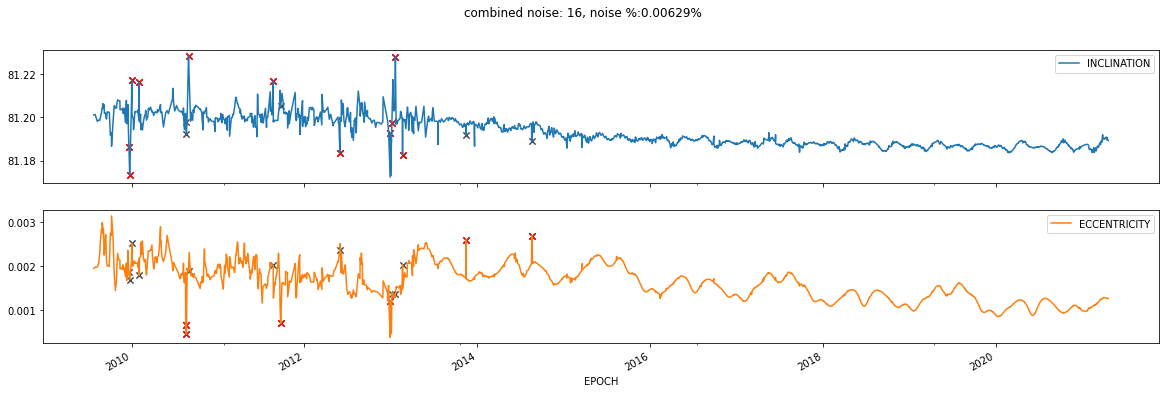

norad id: 36390, rows:1706
column: INCLINATION, n_clusters_: 1, n_noise_: 9, noise %:0.00528%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 4, noise %:0.00234%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 36390, rows:1706, combined noise count: 12, noise %:0.00703%


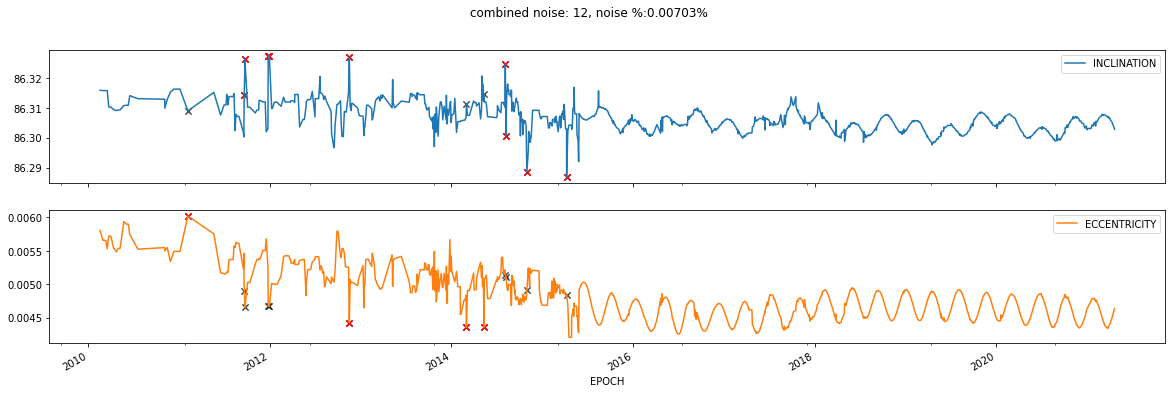

norad id: 36561, rows:421
column: INCLINATION, n_clusters_: 1, n_noise_: 2, noise %:0.00475%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 1, noise %:0.00238%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 36561, rows:421, combined noise count: 2, noise %:0.00475%


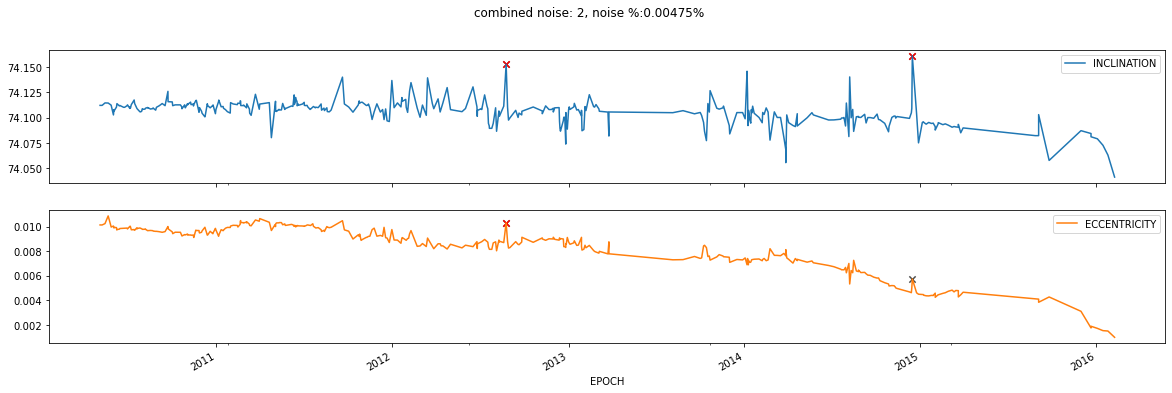

norad id: 37662, rows:1748
column: INCLINATION, n_clusters_: 1, n_noise_: 3, noise %:0.00172%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 5, noise %:0.00286%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 37662, rows:1748, combined noise count: 8, noise %:0.00458%


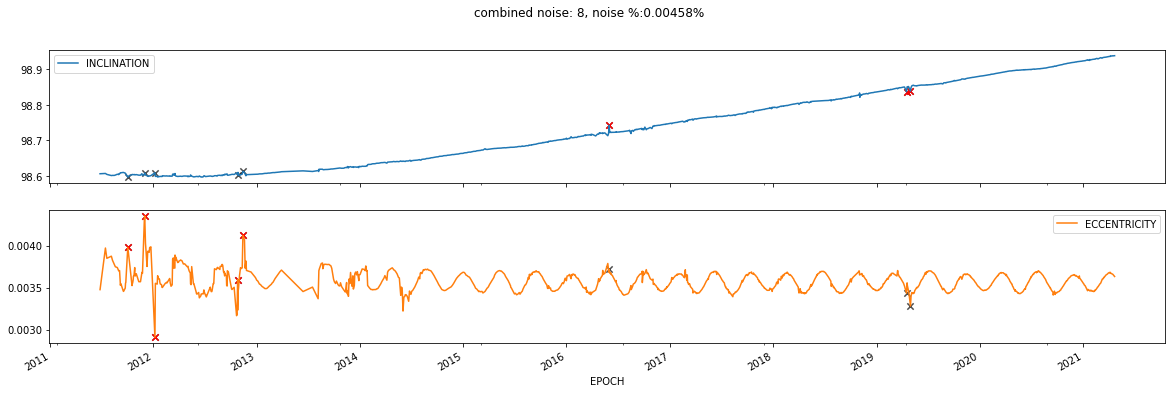

norad id: 37718, rows:407
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.00246%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 3, noise %:0.00737%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 37718, rows:407, combined noise count: 4, noise %:0.00983%


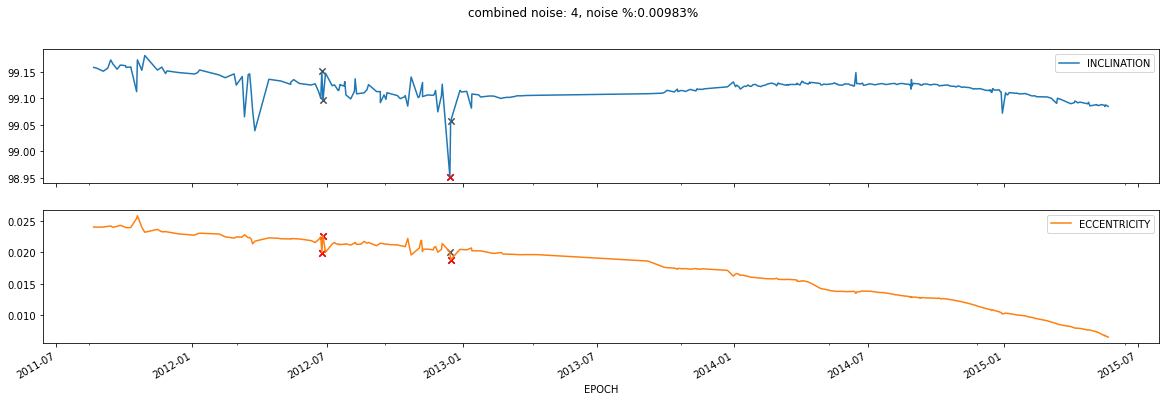

norad id: 38301, rows:2996
column: INCLINATION, n_clusters_: 1, n_noise_: 9, noise %:0.00300%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 5, noise %:0.00167%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 38301, rows:2996, combined noise count: 13, noise %:0.00434%


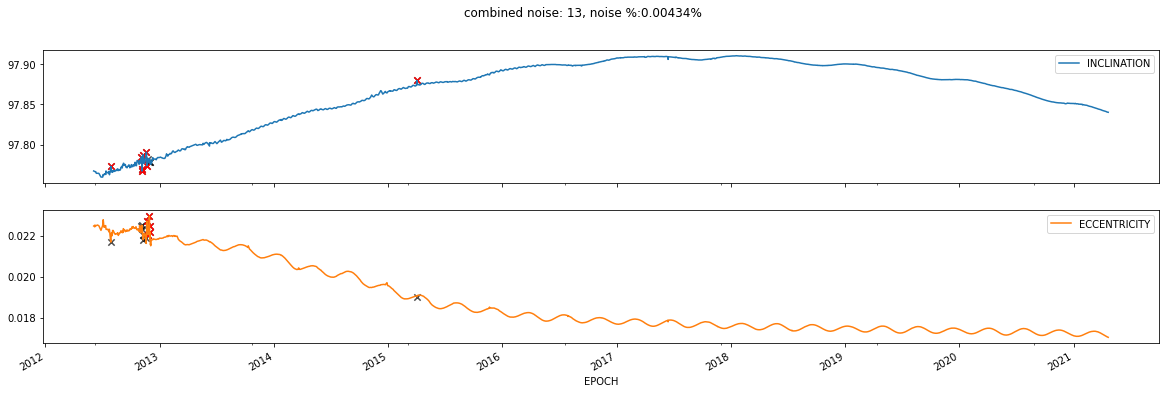

norad id: 38899, rows:665
column: INCLINATION, n_clusters_: 1, n_noise_: 6, noise %:0.00902%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 2, noise %:0.00301%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1]
norad id: 38899, rows:665, combined noise count: 8, noise %:0.01203%


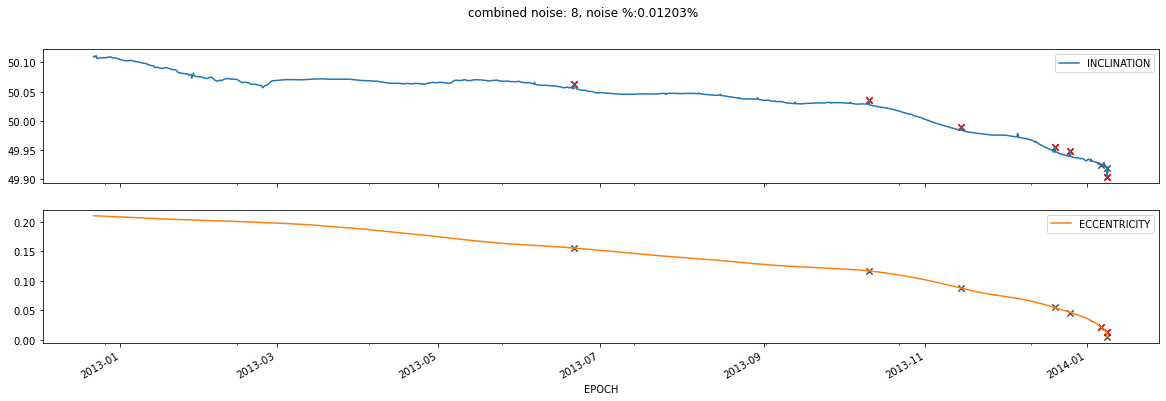

norad id: 42126, rows:934
column: INCLINATION, n_clusters_: 1, n_noise_: 2, noise %:0.00214%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 4, noise %:0.00428%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
norad id: 42126, rows:934, combined noise count: 5, noise %:0.00535%


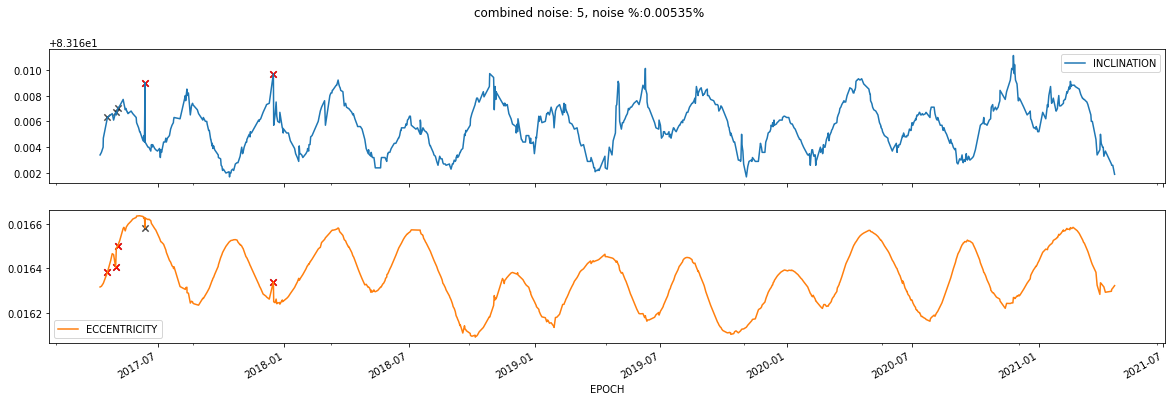

In [107]:
# testing DBSCAN

from sklearn.cluster import DBSCAN

def dbscan_removal(df, debug=False):
#     columns = ["INCLINATION","ECCENTRICITY","MEAN_MOTION"]
    # mean motion turns out to be not very good, due to the final decay as well as outliers reflected in other fields as well
    columns = ["INCLINATION","ECCENTRICITY"]

    def detect_outliers(input_df):
        name = input_df.name
        dbscan_min_samples = max(len(input_df)/100, 20)
        
        sub_df = input_df[columns + ['EPOCH']].set_index('EPOCH', append=True).sort_index(level=1)
        print(f"=============================\nnorad id: {name}, rows:{len(input_df)}")

        ax = (sub_df.droplevel(0)).plot(subplots=True,figsize=(20,6));
        outlier_labels = []
        for i,column in enumerate(columns):
            col_diff = np.minimum(sub_df[column].diff()**2, sub_df[column].diff(-1)**2).fillna(0) + np.minimum(sub_df[column].diff(2)**2, sub_df[column].diff(-2)**2).fillna(0)
            db = DBSCAN(eps=col_diff.std()*3, min_samples=dbscan_min_samples).fit(col_diff.to_frame())
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)    

            print(f"column: {column}, n_clusters_: {n_clusters_}, n_noise_: {n_noise_}, noise %:{n_noise_/len(input_df):.5f}%")
            
            outliers = sub_df[(labels==-1)][column]
            outliers.name = column
            outlier_labels.append(labels)

            ax[i].scatter(outliers.index.get_level_values(1), outliers, s=40, color="red", alpha=1, marker="x", zorder=-1)
#             ax[i].set_title=f"{column} #clusters: {n_clusters_}, #noise: {n_noise_}, noise %:{n_noise_/len(input_df):.5f}%"
            ax[i].set_title=f"AAAAAA"
        
        
        all_normal = (np.array(outlier_labels).T.min(axis=1) != -1)
        print(f"last 30 {all_normal[-30:].astype(int)}")
        num_all_outliers = len(input_df)-np.sum(all_normal)
        outlier_data = sub_df[~all_normal]
        ax[-1].figure.suptitle(f"combined noise: {num_all_outliers}, noise %:{num_all_outliers/len(input_df):.5f}%")
        print(f"norad id: {name}, rows:{len(input_df)}, combined noise count: {num_all_outliers}, noise %:{num_all_outliers/len(input_df):.5f}%")
        for i,column in enumerate(columns):
            ax[i].scatter(outlier_data.index.get_level_values(1), outlier_data[column], s=40, color="black", alpha=0.7, marker="x", zorder=-2)
        
        plt.show()
        return input_df
    
    df.groupby(by="NORAD_CAT_ID", as_index=False).progress_apply(detect_outliers)
    
# dbscan_removal(masked_sample_df[(masked_sample_df.EPOCH > "1991-9") & (masked_sample_df.EPOCH < "1992") & (masked_sample_df.NORAD_CAT_ID == 12223)])
# dbscan_removal(masked_sample_df[(masked_sample_df.NORAD_CAT_ID == 330)])
# dbscan_removal(masked_sample_df[(masked_sample_df.NORAD_CAT_ID.isin([20970, 26285]))])
treated_df = dbscan_removal(masked_sample_df)

# Save DataFrame with anomaly removed

Both `full` and `min` version is saved to `2_full` and `2_min` in the shared data folder.

In [ ]:
# %%time
# train_df[combined].to_pickle(f"{os.environ['GP_HIST_PATH']}/../2_min/train.pkl")
# train_df_full = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../0_full/train.pkl")
# train_df_full[combined].to_pickle(f"{os.environ['GP_HIST_PATH']}/../2_full/train.pkl")
# del train_df_full